In [168]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

In [169]:
data = pd.read_csv('https://raw.githubusercontent.com/josh-g-grimes/Regression-Analysis---College-Exam-Performance/main/StudentPerformanceFactors.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [170]:
#Drop Missing Values
data = data.dropna()

In [171]:
#Separate columns into numerical and categorical data
categoricals = data.select_dtypes(include='object')
numericals = data.select_dtypes(exclude='object')

In [172]:
#Inspect the value counts for the categorical features
for col in categoricals.columns:
    print(categoricals[col].value_counts())
    print()

Parental_Involvement
Medium    3251
High      1836
Low       1291
Name: count, dtype: int64

Access_to_Resources
Medium    3204
High      1900
Low       1274
Name: count, dtype: int64

Extracurricular_Activities
Yes    3807
No     2571
Name: count, dtype: int64

Motivation_Level
Medium    3237
Low       1864
High      1277
Name: count, dtype: int64

Internet_Access
Yes    5893
No      485
Name: count, dtype: int64

Family_Income
Low       2582
Medium    2566
High      1230
Name: count, dtype: int64

Teacher_Quality
Medium    3826
High      1905
Low        647
Name: count, dtype: int64

School_Type
Public     4434
Private    1944
Name: count, dtype: int64

Peer_Influence
Positive    2553
Neutral     2495
Negative    1330
Name: count, dtype: int64

Learning_Disabilities
No     5710
Yes     668
Name: count, dtype: int64

Parental_Education_Level
High School     3159
College         1939
Postgraduate    1280
Name: count, dtype: int64

Distance_from_Home
Near        3801
Moderate    1941
Fa

In [173]:
#Find the most correlated numerical value to the target variable
data.corr(numeric_only=True)["Exam_Score"]

,Exam_Score
Hours_Studied,0.445104
Attendance,0.580259
Sleep_Hours,-0.017171
Previous_Scores,0.174283
Tutoring_Sessions,0.156829
Physical_Activity,0.025148
Exam_Score,1.000000


<Axes: xlabel='Attendance', ylabel='Exam_Score'>

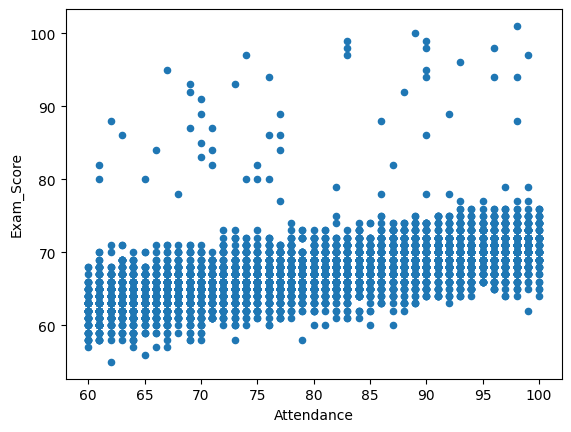

In [174]:
#scatter plot attendance verse exam score
data.plot.scatter(x='Attendance', y='Exam_Score')

In [176]:
#Assign Variables
X_baseline = data['Attendance']
y = data['Exam_Score']

In [178]:
#Create a single linear regression model using only the most correlated variable as a baseline
single_linear_regression = sm.OLS(y, sm.add_constant(X_baseline))
single_linear_regression_results = single_linear_regression.fit()
print(single_linear_regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     3237.
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        00:37:11   Log-Likelihood:                -16444.
No. Observations:                6378   AIC:                         3.289e+04
Df Residuals:                    6376   BIC:                         3.291e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.5173      0.279    184.356      0.0

In [156]:
#fit a one hot encoder to the categorical data
ohe = OneHotEncoder(drop='first')
categoricals_trans = ohe.fit_transform(categoricals)

In [157]:
#create a matrix from the transformed categorical data
categoricals_trans.todense()

matrix([[1., 0., 0., ..., 0., 1., 1.],
        [1., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 1., 1.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 1., 1.]])

In [158]:
#turn the matrix into a dataframe
categoricals_ohe = pd.DataFrame(categoricals_trans.todense(), columns=ohe.get_feature_names_out())

In [159]:
#combine the reformated categorical columns with the numerical columns
data = pd.concat([numericals, categoricals_ohe], axis=1)

In [160]:
data = data.dropna()

In [161]:
X = data.drop(columns= 'Exam_Score', axis=1)
y = data['Exam_Score']

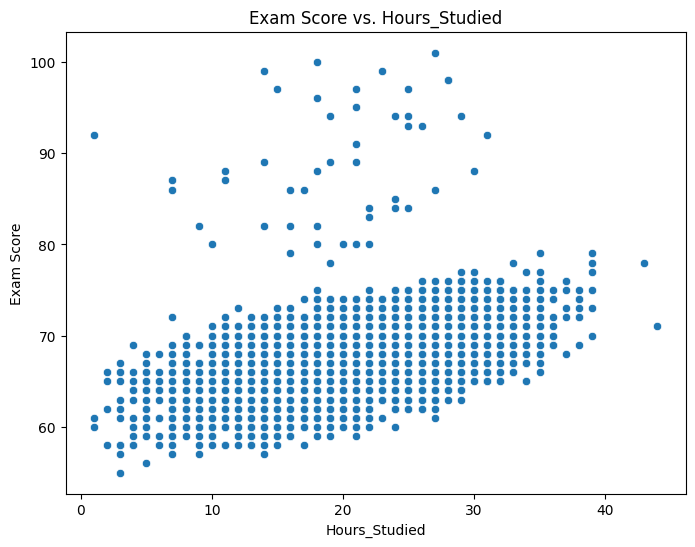

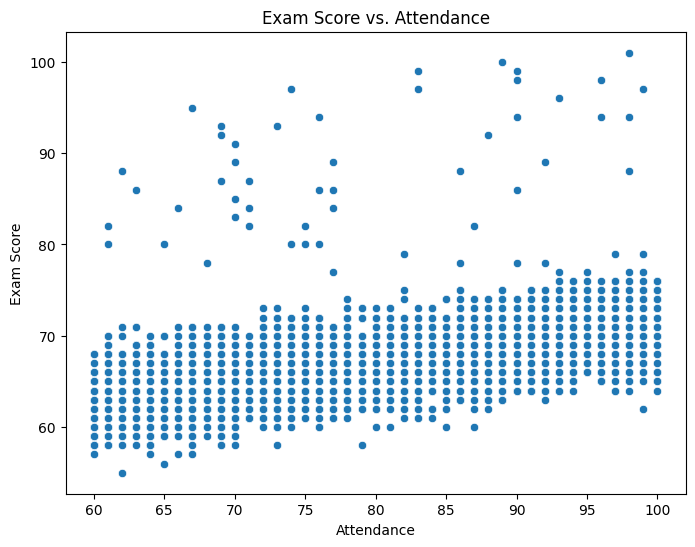

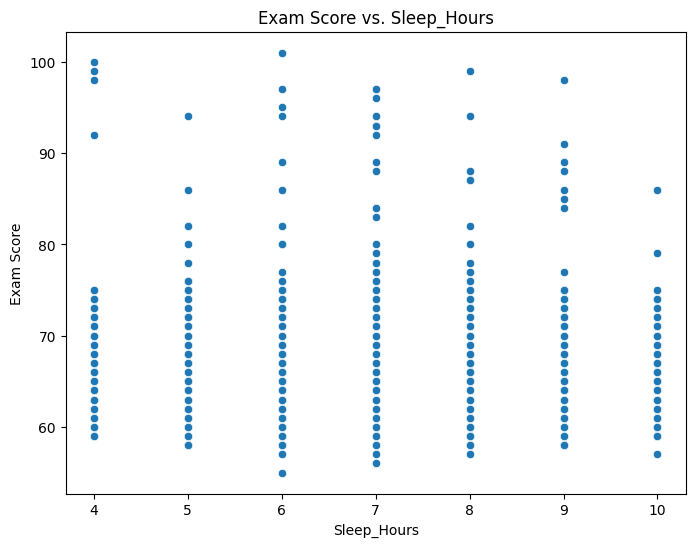

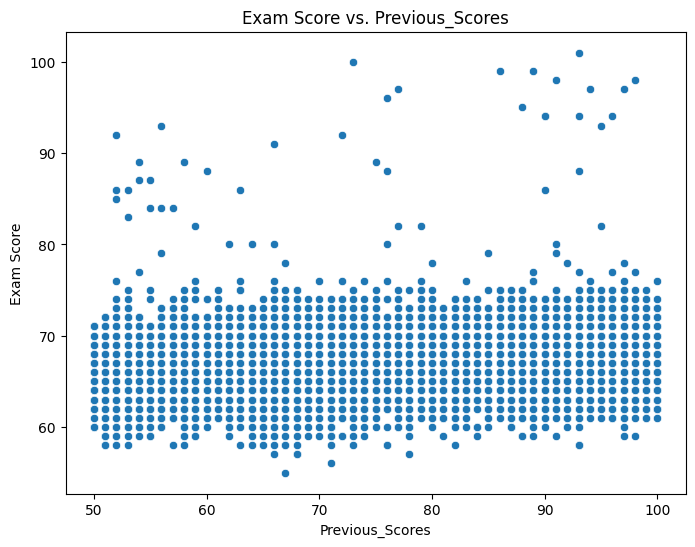

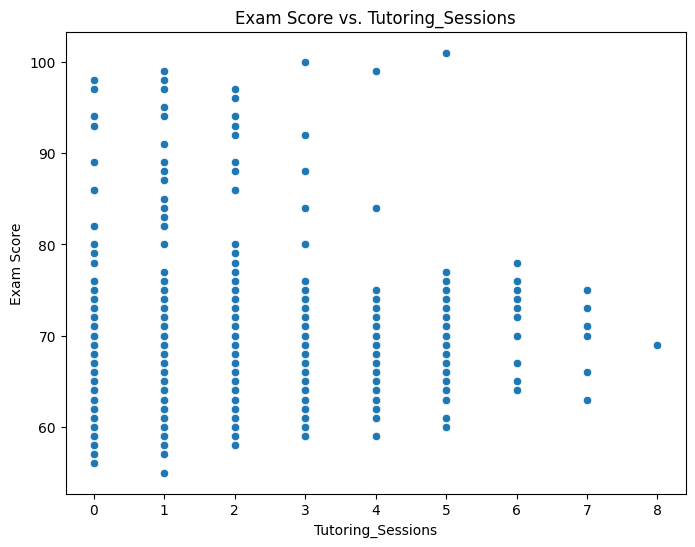

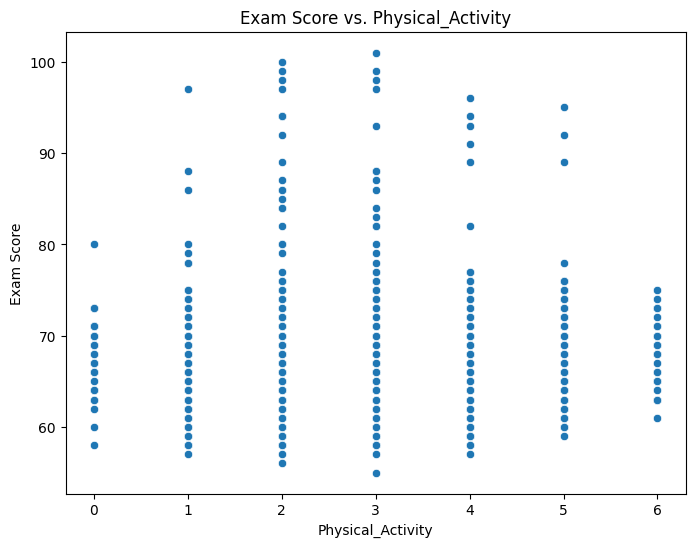

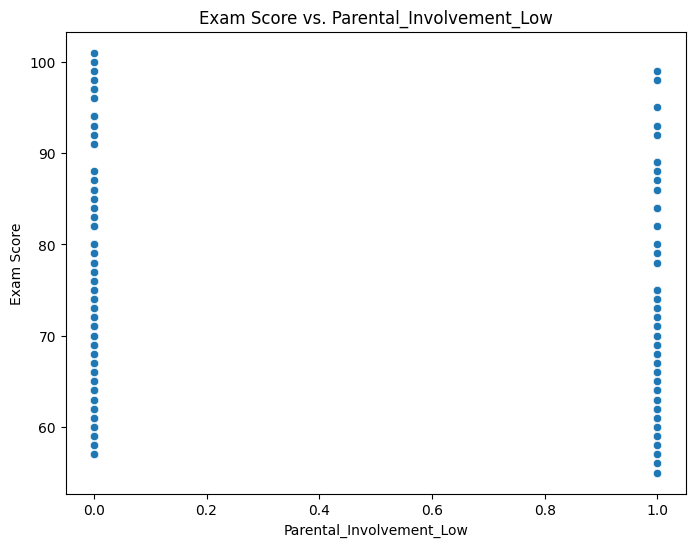

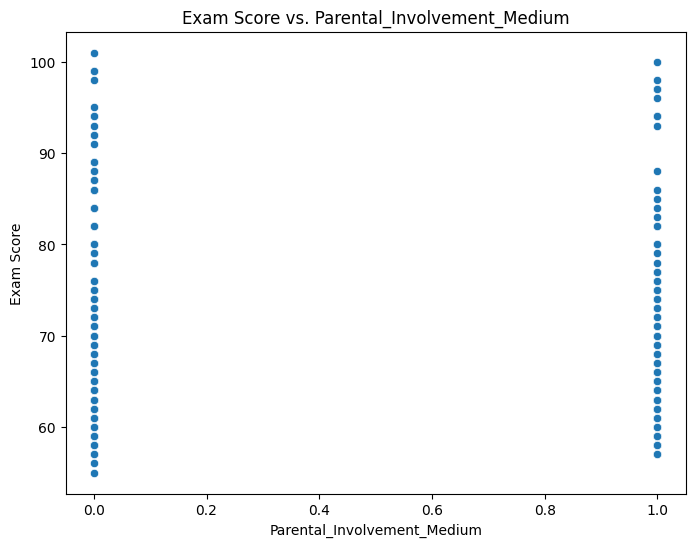

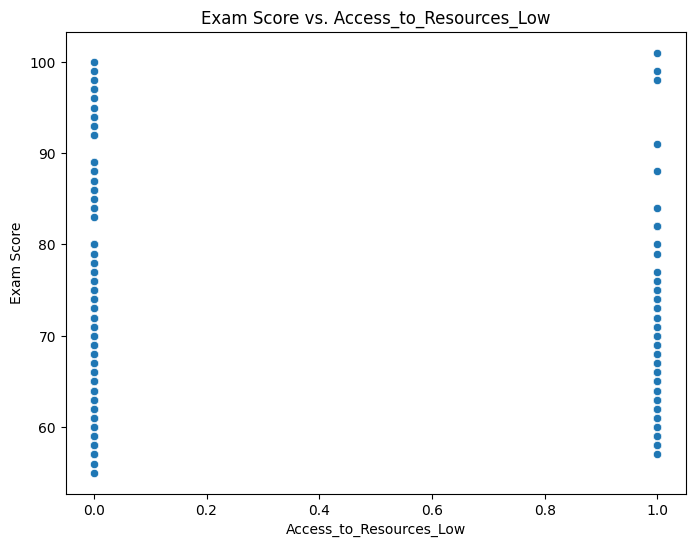

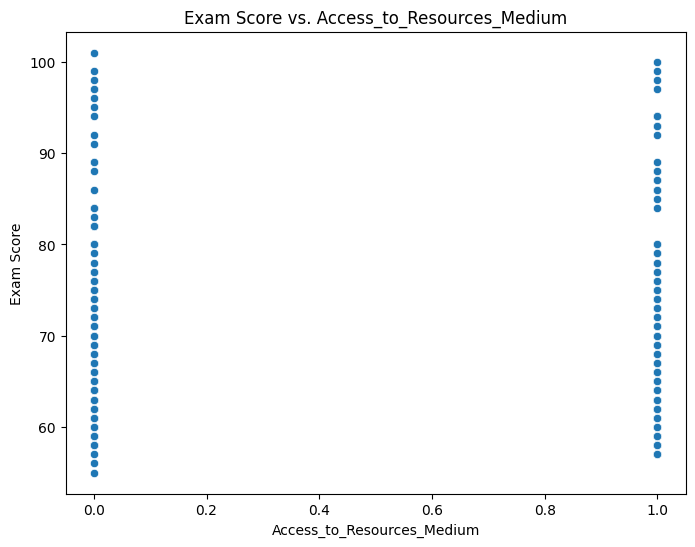

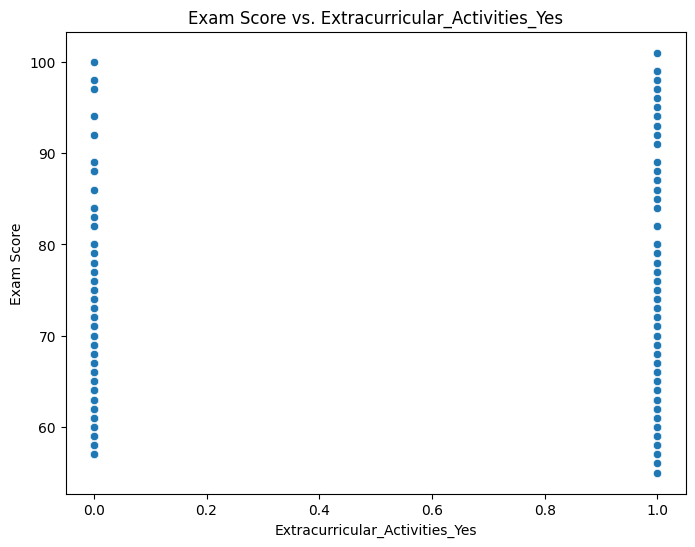

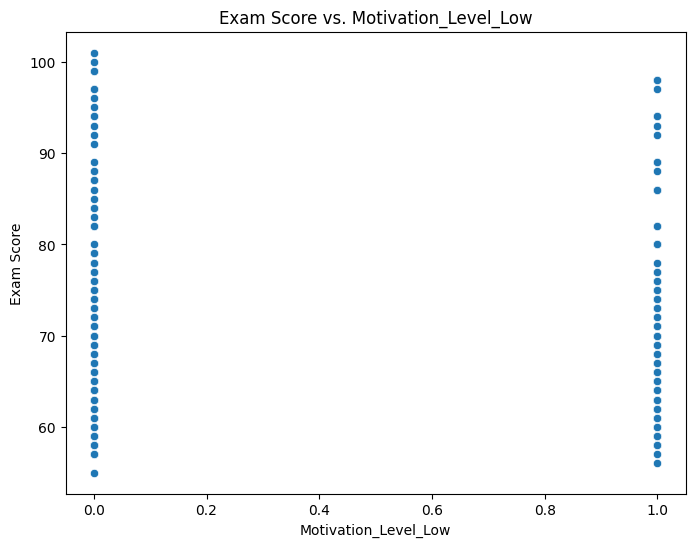

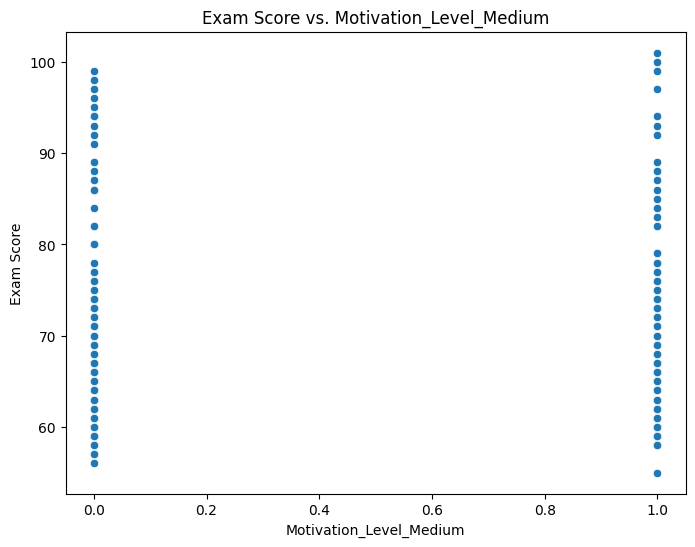

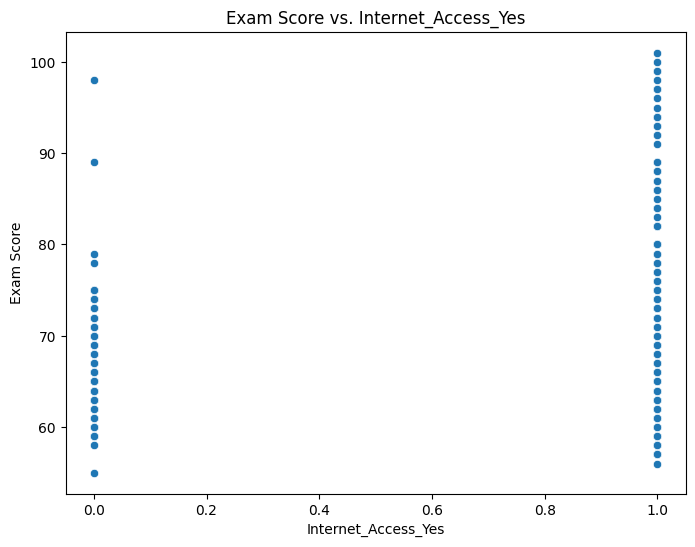

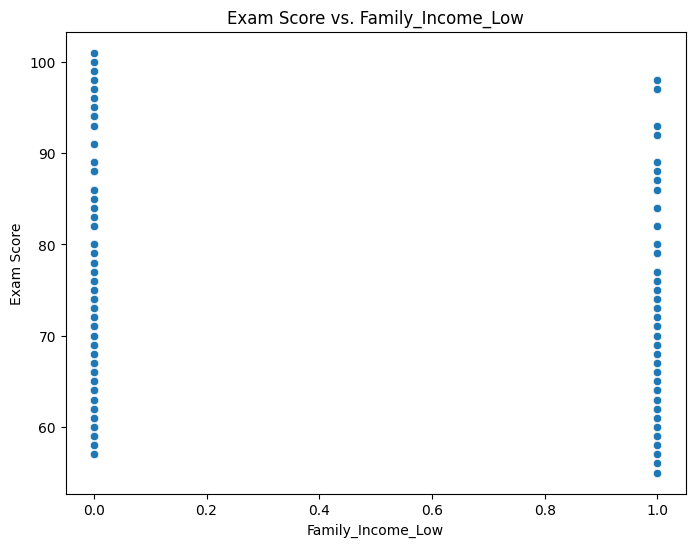

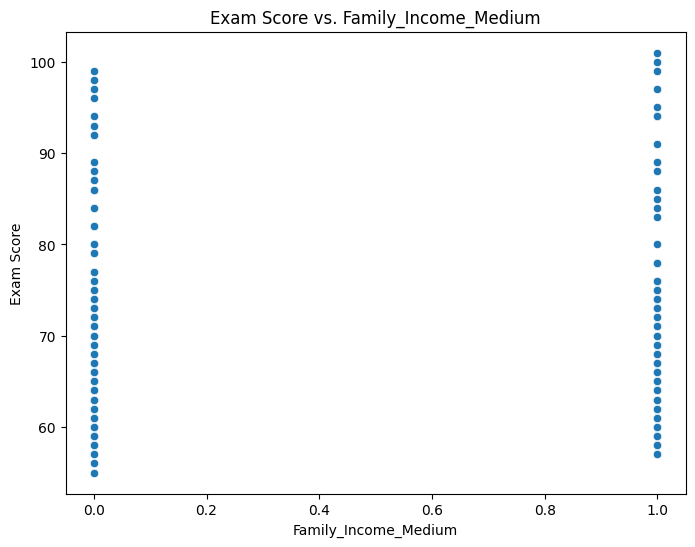

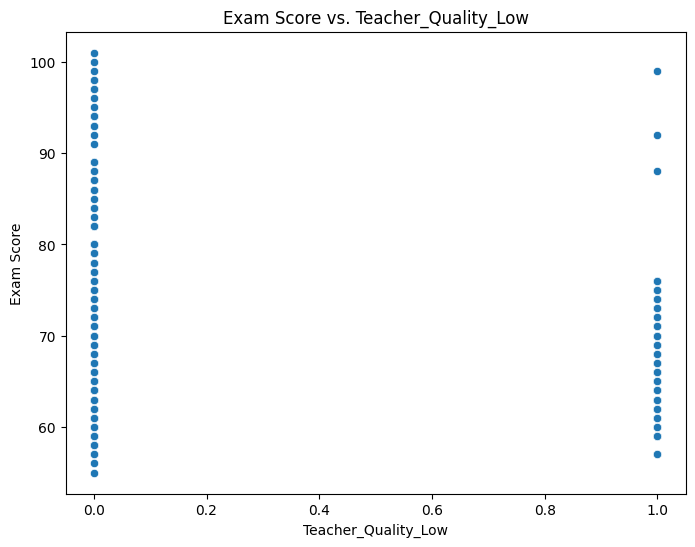

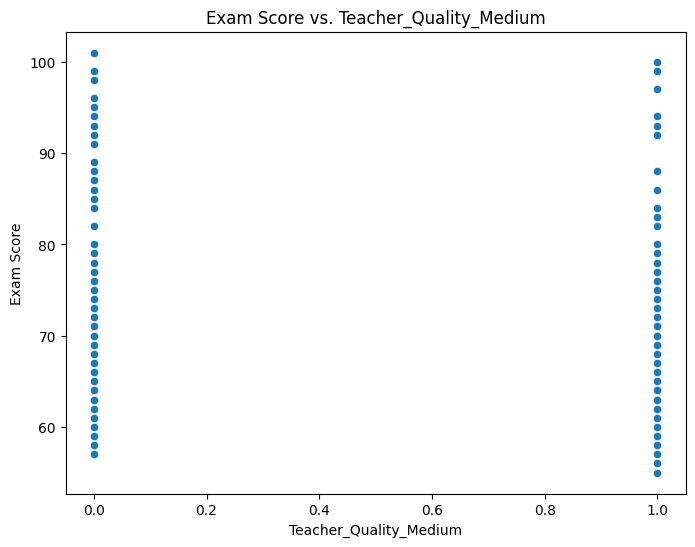

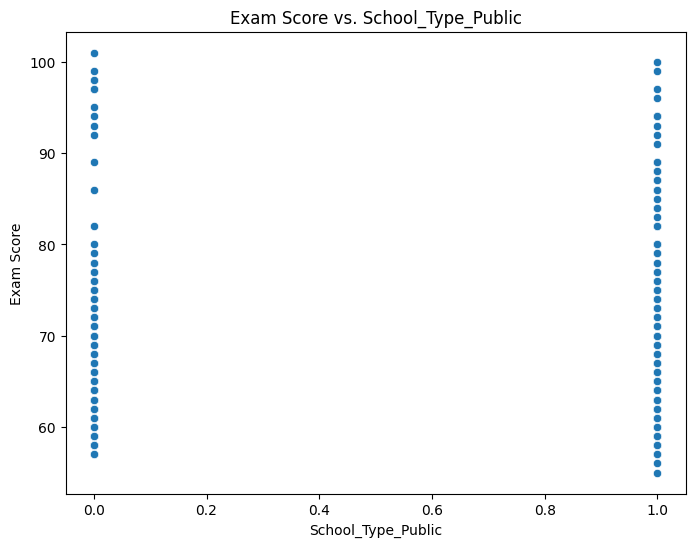

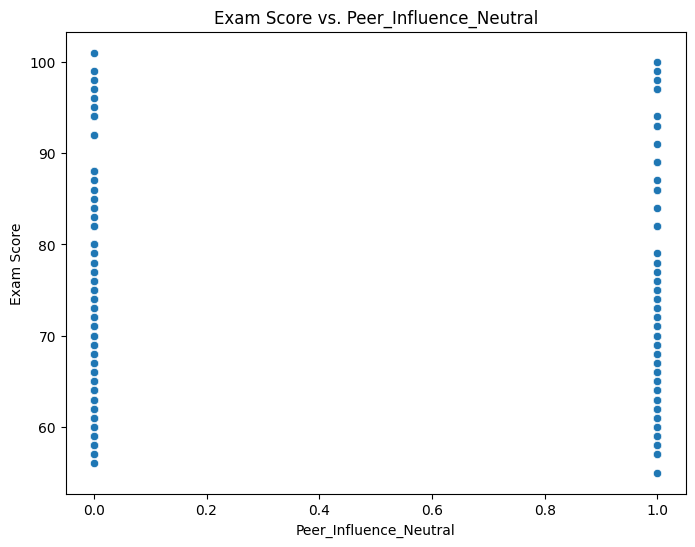

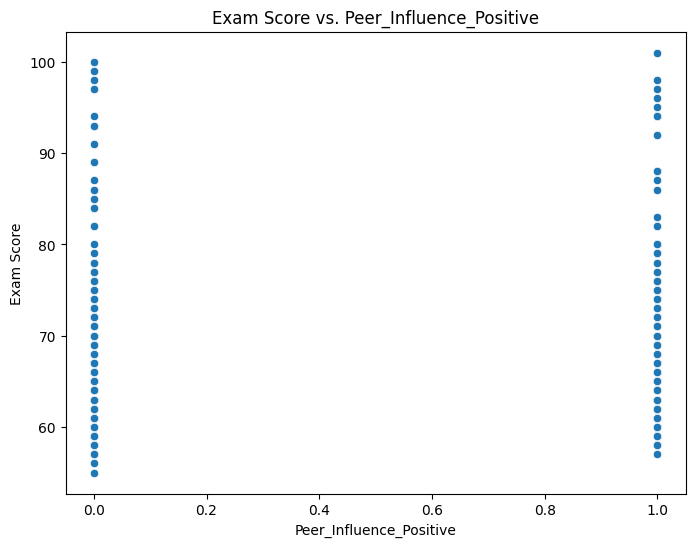

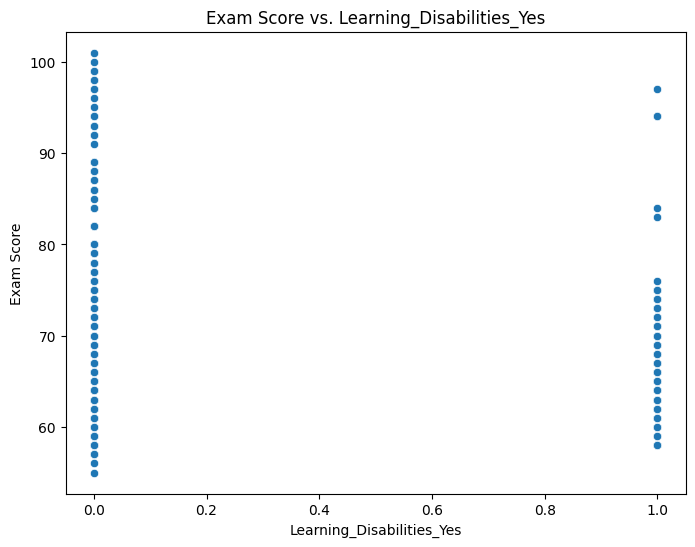

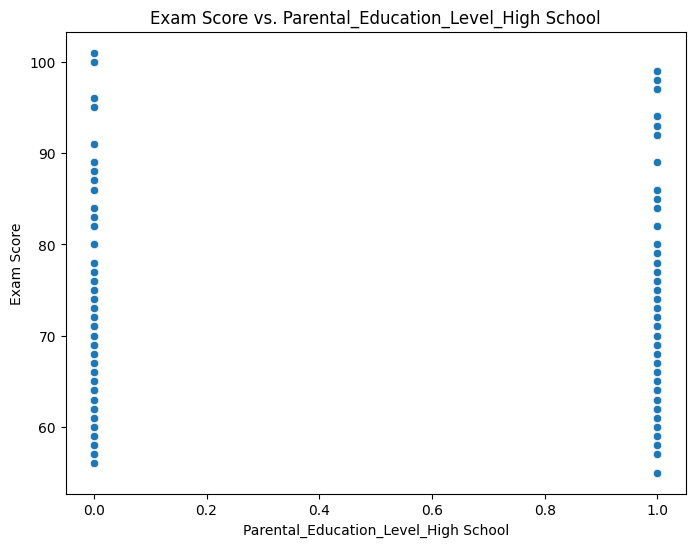

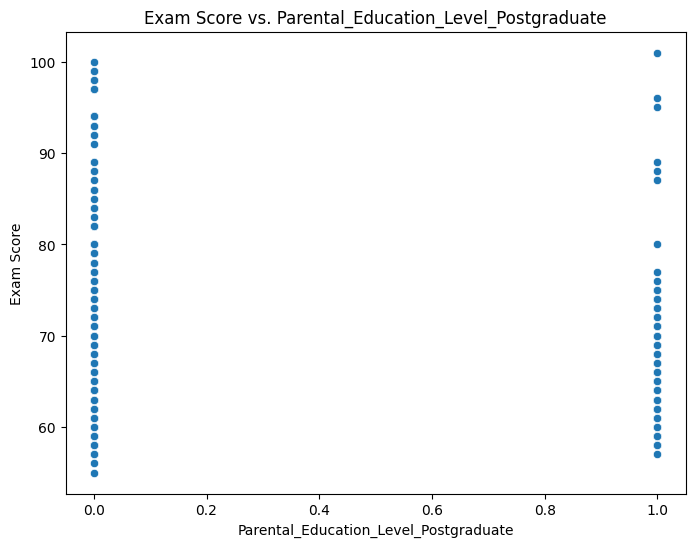

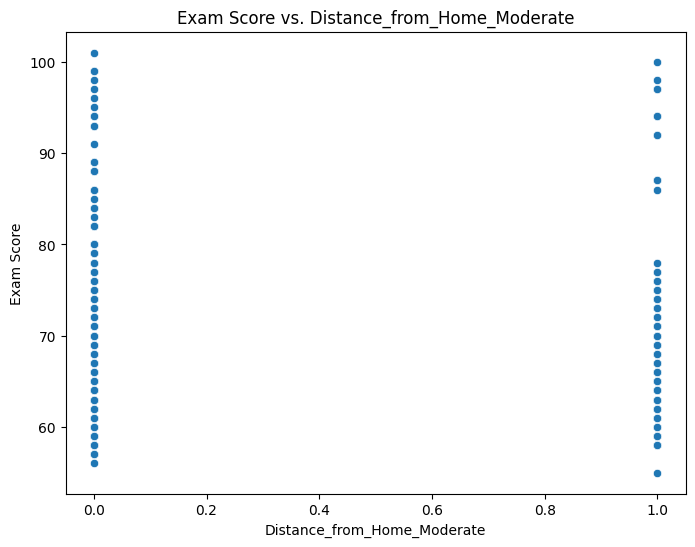

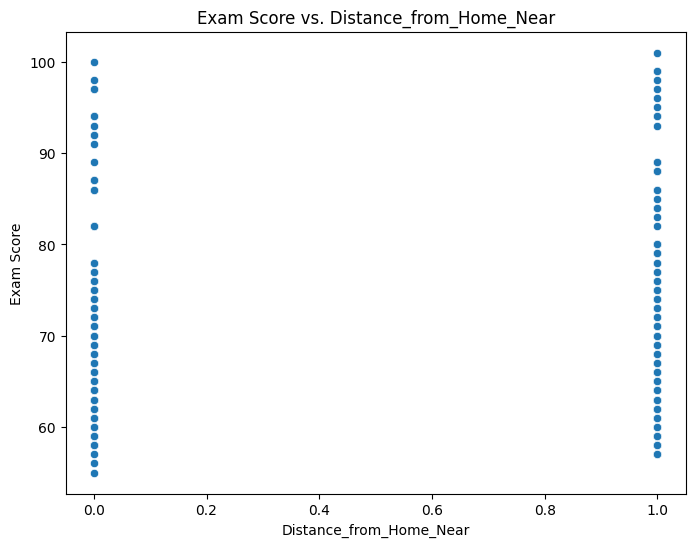

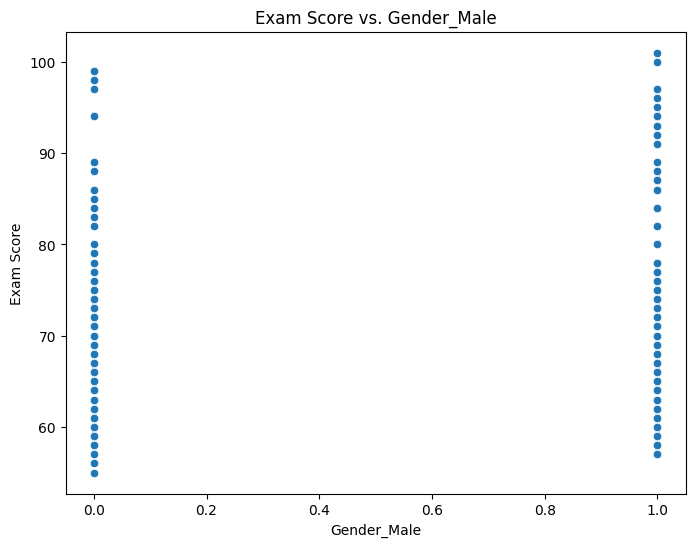

In [162]:
for col in X.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='Exam_Score', data=data)
    plt.title(f'Exam Score vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Exam Score')
    plt.show()

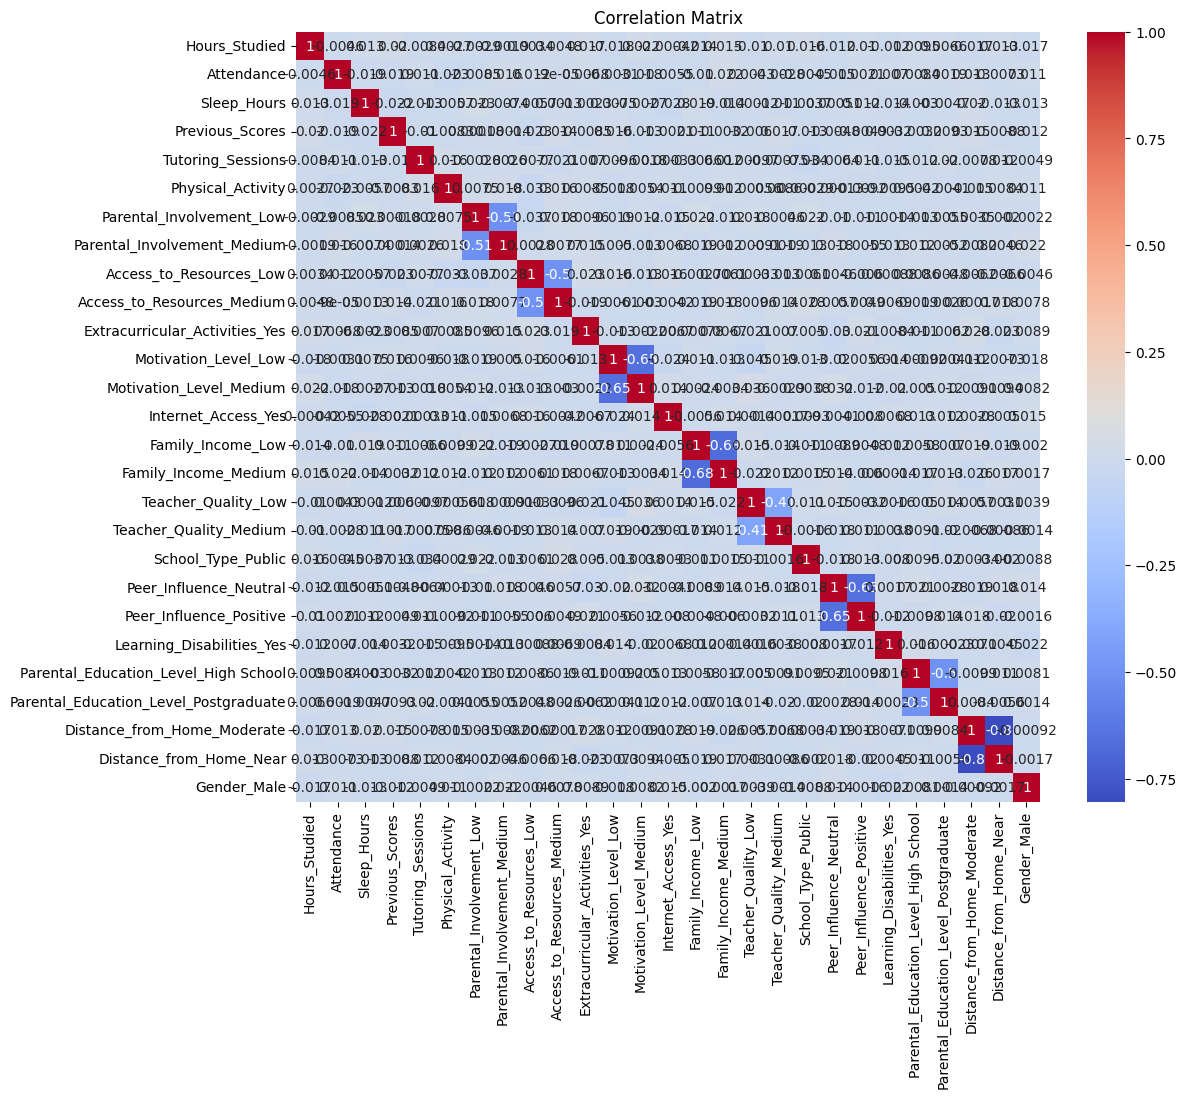

In [163]:
# Correlation matrix
correlation_matrix = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [124]:
baseline_modle = sm.OLS(endog=y, exog=X)
baseline_results = baseline_modle.fit()
baseline_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Exam_Score   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          6.463e+04
Date:                Tue, 17 Sep 2024   Prob (F-statistic):                        0.00
Time:                        20:23:30   Log-Likelihood:                         -17266.
No. Observations:                6162   AIC:                                  3.459e+04
Df Residuals:                    6135   BIC:                                  3.477e+04
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Hours_Studied                             0.4189      0.008     50.638      0.000       0.403       0.435
Attendance                                0.3462      0.004     93.815      0.000       0.339       0.353
Sleep_Hours                               0.8075      0.032     25.305      0.000       0.745       0.870
Previous_Scores                           0.1387      0.003     43.000      0.000       0.132       0.145
Tutoring_Sessions                         0.7379      0.041     17.928      0.000       0.657       0.819
Physical_Activity                         0.8472      0.048     17.614      0.000       0.753       0.941
Parental_Involvement_Low                  0.9295      0.147      6.311      0.000       0.641       1.218
Parental_Involvement_Medium               0.7322      0.118      6.186      0.000       0.500       0.964
Access_to_Resources_Low                   0.8253      0.147      5.616      0.000       0.537       1.113
Access_to_Resources_Medium                0.6665      0.117      5.680      0.000       0.436       0.897
Extracurricular_Activities_Yes            0.5931      0.104      5.723      0.000       0.390       0.796
Motivation_Level_Low                      1.4312      0.146      9.777      0.000       1.144       1.718
Motivation_Level_Medium                   1.2635      0.133      9.493      0.000       1.003       1.524
Internet_Access_Yes                       3.2918      0.184     17.875      0.000       2.931       3.653
Family_Income_Low                         1.1114      0.140      7.964      0.000       0.838       1.385
Family_Income_Medium                      0.9735      0.140      6.955      0.000       0.699       1.248
Teacher_Quality_Low                       0.6148      0.185      3.317      0.001       0.251       0.978
Teacher_Quality_Medium                    0.6154      0.113      5.430      0.000       0.393       0.838
School_Type_Public                        0.7512      0.110      6.826      0.000       0.536       0.967
Peer_Influence_Neutral                    1.3829      0.137     10.105      0.000       1.115       1.651
Peer_Influence_Positive                   1.3450      0.136      9.876      0.000       1.078       1.612
Learning_Disabilities_Yes                 0.3846      0.167      2.310      0.021       0.058       0.711
Parental_Education_Level_High School      0.6507      0.117      5.559      0.000       0.421       0.880
Parental_Education_Level_Postgraduate     0.5494      0.146      3.753      0.000       0.262       0.836
Distance_from_Home_Moderate               2.1845      0.183     11.968      0.000       1.827       2.542
Distance_from_Ho

In [134]:
model_add_constant = sm.OLS(endog=y, exog=sm.add_constant(X))
constant_results = model_add_constant.fit()
constant_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Exam_Score   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     340.8
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:21:11   Log-Likelihood:                -14306.
No. Observations:                6162   AIC:                         2.867e+04
Df Residuals:                    6134   BIC:                         2.886e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    41.0938      0.413     99.489      0.000      40.284      41.904
Hours_Studied                             0.2929      0.005     55.554      0.000       0.283       0.303
Attendance                                0.1977      0.003     72.485      0.000       0.192       0.203
Sleep_Hours                              -0.0173      0.021     -0.809      0.419      -0.059       0.025
Previous_Scores                           0.0480      0.002     21.909      0.000       0.044       0.052
Tutoring_Sessions                         0.4993      0.026     19.524      0.000       0.449       0.549
Physical_Activity                         0.1320      0.031      4.313      0.000       0.072       0.192
Parental_Involvement_Low                  0.1647      0.091      1.801      0.072      -0.015       0.344
Parental_Involvement_Medium               0.0150      0.074      0.204      0.838      -0.129       0.159
Access_to_Resources_Low                  -0.0056      0.091     -0.061      0.952      -0.185       0.173
Access_to_Resources_Medium               -0.0265      0.073     -0.364      0.716      -0.170       0.116
Extracurricular_Activities_Yes            0.0178      0.064      0.277      0.782      -0.108       0.144
Motivation_Level_Low                      0.0749      0.092      0.818      0.413      -0.105       0.254
Motivation_Level_Medium                  -0.0260      0.083     -0.312      0.755      -0.189       0.137
Internet_Access_Yes                       0.0514      0.118      0.433      0.665      -0.181       0.284
Family_Income_Low                        -0.0862      0.087     -0.989      0.323      -0.257       0.085
Family_Income_Medium                     -0.1374      0.087     -1.574      0.116      -0.309       0.034
Teacher_Quality_Low                      -0.1448      0.115     -1.260      0.208      -0.370       0.080
Teacher_Quality_Medium                   -0.1487      0.071     -2.108      0.035      -0.287      -0.010
School_Type_Public                       -0.0850      0.069     -1.240      0.215      -0.220       0.049
Peer_Influence_Neutral                    0.1155      0.086      1.349      0.177      -0.052       0.283
Peer_Influence_Positive                   0.1230      0.085      1.444      0.149      -0.044       0.290
Learning_Disabilities_Yes                -0.0234      0.103     -0.227      0.820      -0.225       0.179
Parental_Education_Level_High School      0.0141      0.073      0.194      0.846      -0.128       0.157
Parental_Education_Level_Postgraduate    -0.0360      0.091     -0.397      0.692      -0.214       0.142
Distance_from_Home_Moderate              -0.1004      0.115     -0.871      0.384      -0.326       0.126
Distance_

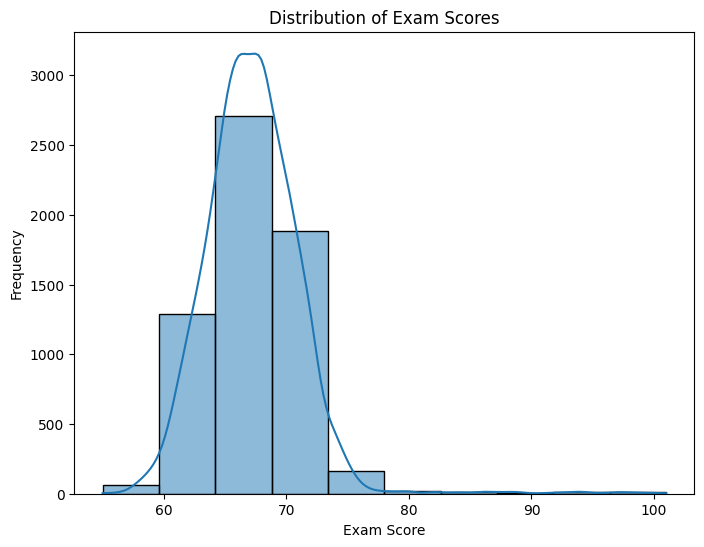

In [132]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Exam_Score'], bins=10, kde=True)
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.show()
